In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from torchvision.models.video import mvit_v2_s, MViT_V2_S_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_video
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from video_saccade_detection import detect_saccades_from_video, detect_saccades_from_video_simple

print("All modules loaded")

All modules loaded


In [2]:
# Define paths
DATA_DIR = './eyeVideos'
CSV_FILE = './video_labels.csv'

# Load labels from CSV
labels_df = pd.read_csv(CSV_FILE)
labels_dict = {row['filename']: row['label'] for _, row in labels_df.iterrows()}

# Custom Video Dataset
class VideoDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.video_paths = list(labels_dict.keys())

    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_name = self.video_paths[idx]
        video_path = os.path.join(self.root_dir, video_name)
        pupil_path = os.path.join(self.root_dir, video_name.replace("_video.mp4", "_pupil.mp4"))
        wavef_path = os.path.join(self.root_dir, video_name.replace("_video.mp4", "_wavef.csv"))

        video, _, _ = read_video(video_path, pts_unit='sec')  # Load full video

        video_saccade_indices = self.find_saccade_from_video_and_stimulus(video_path, wavef_path, fps=60)
        random_saccade_index = np.random.choice(video_saccade_indices)
        video = self.select_frames(video, starting_frame=random_saccade_index, num_frames=32, interval=1)

        video = video.permute(3, 0, 1, 2)  # Convert (Frames, H, W, C) → (C, Frames, H, W)
        video = video.float() / 255.0  # Normalize

        if self.transform:
            video = self.transform(video)

        label = self.labels_dict[video_name]
        return video, label

    @staticmethod
    def find_saccade_from_video_and_stimulus(video_path, csv_path, fps=60):
        df = pd.read_csv(csv_path)  # Replace with your file
        stimulus = df["target"].values  # Extract the stimulus column
        saccade_vector_video_final = detect_saccades_from_video_simple(video_path, stimulus, fps)
        video_saccade_indices = np.arange(len(stimulus))[saccade_vector_video_final==1]
        return video_saccade_indices

    @staticmethod
    def select_frames(video, num_frames=16, interval=1, starting_frame=None):    # shape: (Frames, H, W, C)
        quater_frame = num_frames // 4
        return video[starting_frame-quater_frame*interval:starting_frame+3*quater_frame*interval:interval]

torch.Size([3, 32, 256, 256]) 0 normal_2_163_video.mp4


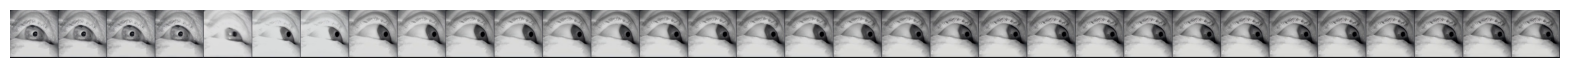

In [4]:
# Load one sample from the dataset
dataset = VideoDataset(DATA_DIR, labels_dict)

# Get the first video and label
video_sample, label = dataset[0]

# Print video shape and label
video_shape = video_sample.shape  # (C, Frames, H, W)
video_filename = dataset.video_paths[0]

print(video_shape, label, video_filename)

import matplotlib.pyplot as plt
# Function to display video frames concatenated horizontally
def show_video_frames(video_tensor):
    # Permute the tensor to (Frames, H, W, C) for easier handling
    video_tensor = video_tensor.permute(1, 2, 3, 0)
    frames = [video_tensor[i].numpy() for i in range(video_tensor.shape[0])]
    
    # Concatenate frames horizontally
    concatenated_frames = np.concatenate(frames, axis=1)
    
    # Display the concatenated frames
    plt.figure(figsize=(20, 10))
    plt.imshow(concatenated_frames)
    plt.axis('off')
    plt.show()

# Example usage
show_video_frames(video_sample)


In [5]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load Dataset
dataset = VideoDataset(DATA_DIR, labels_dict, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load R(2+1)D model
    # Jooyoung's way:
    # weights = R2Plus1D_18_Weights.DEFAULT
    # model = r2plus1d_18(weights=weights)

# Offline loading:
def load_model_offline(model_name, pth_path, ignore_key):
    model = model_name(weights=None, num_classes=3)
    state_dict = torch.load(pth_path, weights_only=True)
    # Remove parameters from the head if they exist in the state dict
    for key in list(state_dict.keys()):
        if key.startswith(ignore_key):
            print(f"Removing {key} from checkpoint due to shape mismatch.")
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    return model
model = load_model_offline(r2plus1d_18, "./pretrained_weights/r2plus1d_18-91a641e6.pth", ignore_key="fc")
# model = load_model_offline(mvit_v2_s,"./pretrained_weights/mvit_v2_s-ae3be16 7.pth", ignore_key="head")

model = model.cuda()

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
training_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, total=len(train_loader))
    for inputs, labels in pbar:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        training_loss.append(loss.item())
        pbar.set_postfix(dict(running_loss=loss.item()))
        pbar.update()
    pbar.close()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Training completed!")

Removing fc.weight from checkpoint due to shape mismatch.
Removing fc.bias from checkpoint due to shape mismatch.


100%|██████████| 73/73 [00:19<00:00,  3.77it/s, running_loss=1.19] 


Epoch 1/50, Loss: 1.1062462836095732


100%|██████████| 73/73 [00:17<00:00,  4.17it/s, running_loss=1.08] 


Epoch 2/50, Loss: 0.9953500024259907


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.757]


Epoch 3/50, Loss: 0.7407768038037705


100%|██████████| 73/73 [00:17<00:00,  4.09it/s, running_loss=0.523]


Epoch 4/50, Loss: 0.615145500800381


100%|██████████| 73/73 [00:17<00:00,  4.13it/s, running_loss=1.05] 


Epoch 5/50, Loss: 0.5301425158977509


100%|██████████| 73/73 [00:17<00:00,  4.16it/s, running_loss=0.409]


Epoch 6/50, Loss: 0.47712603150165245


100%|██████████| 73/73 [00:17<00:00,  4.15it/s, running_loss=0.384]


Epoch 7/50, Loss: 0.37282122712429255


100%|██████████| 73/73 [00:17<00:00,  4.14it/s, running_loss=0.326]


Epoch 8/50, Loss: 0.3807857737761654


100%|██████████| 73/73 [00:17<00:00,  4.09it/s, running_loss=0.191] 


Epoch 9/50, Loss: 0.2935808231569316


100%|██████████| 73/73 [00:17<00:00,  4.06it/s, running_loss=0.164] 


Epoch 10/50, Loss: 0.26851827763531305


100%|██████████| 73/73 [00:17<00:00,  4.19it/s, running_loss=0.198] 


Epoch 11/50, Loss: 0.266983841124871


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.276] 


Epoch 12/50, Loss: 0.22061773777416308


100%|██████████| 73/73 [00:17<00:00,  4.15it/s, running_loss=0.13]  


Epoch 13/50, Loss: 0.1815347493409294


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.192] 


Epoch 14/50, Loss: 0.18003379915879197


100%|██████████| 73/73 [00:17<00:00,  4.17it/s, running_loss=0.368] 


Epoch 15/50, Loss: 0.15124873847585835


100%|██████████| 73/73 [00:17<00:00,  4.19it/s, running_loss=0.0408]


Epoch 16/50, Loss: 0.19370808666699554


100%|██████████| 73/73 [00:17<00:00,  4.11it/s, running_loss=0.21]  


Epoch 17/50, Loss: 0.15584142141248267


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.411] 


Epoch 18/50, Loss: 0.12641009734305617


100%|██████████| 73/73 [00:17<00:00,  4.09it/s, running_loss=0.25]  


Epoch 19/50, Loss: 0.12019056069014007


100%|██████████| 73/73 [00:17<00:00,  4.08it/s, running_loss=0.0106]


Epoch 20/50, Loss: 0.08743020329522351


100%|██████████| 73/73 [00:17<00:00,  4.13it/s, running_loss=0.0259]


Epoch 21/50, Loss: 0.08395987413568448


100%|██████████| 73/73 [00:17<00:00,  4.13it/s, running_loss=0.0338] 


Epoch 22/50, Loss: 0.12702830068843618


100%|██████████| 73/73 [00:17<00:00,  4.12it/s, running_loss=0.0817] 


Epoch 23/50, Loss: 0.06301733626256863


100%|██████████| 73/73 [00:17<00:00,  4.12it/s, running_loss=0.0614] 


Epoch 24/50, Loss: 0.0962192664969049


100%|██████████| 73/73 [00:17<00:00,  4.18it/s, running_loss=0.0415] 


Epoch 25/50, Loss: 0.07118764214779008


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.155]  


Epoch 26/50, Loss: 0.08075825822195165


100%|██████████| 73/73 [00:17<00:00,  4.12it/s, running_loss=0.0526] 


Epoch 27/50, Loss: 0.04762464134048109


100%|██████████| 73/73 [00:17<00:00,  4.13it/s, running_loss=0.235]  


Epoch 28/50, Loss: 0.05495302463333084


100%|██████████| 73/73 [00:18<00:00,  4.03it/s, running_loss=0.0454] 


Epoch 29/50, Loss: 0.05660524634861273


100%|██████████| 73/73 [00:17<00:00,  4.09it/s, running_loss=0.0579] 


Epoch 30/50, Loss: 0.06272001205050476


100%|██████████| 73/73 [00:17<00:00,  4.08it/s, running_loss=0.0155] 


Epoch 31/50, Loss: 0.06686196017576611


100%|██████████| 73/73 [00:17<00:00,  4.08it/s, running_loss=0.0888] 


Epoch 32/50, Loss: 0.052506162820077716


100%|██████████| 73/73 [00:17<00:00,  4.13it/s, running_loss=0.16]   


Epoch 33/50, Loss: 0.050720352453039325


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.723]  


Epoch 34/50, Loss: 0.09571933103023633


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.305]  


Epoch 35/50, Loss: 0.09987703533460425


100%|██████████| 73/73 [00:17<00:00,  4.07it/s, running_loss=0.0483] 


Epoch 36/50, Loss: 0.06744560163806206


100%|██████████| 73/73 [00:19<00:00,  3.73it/s, running_loss=0.0861] 


Epoch 37/50, Loss: 0.04504555037997867


100%|██████████| 73/73 [00:17<00:00,  4.11it/s, running_loss=0.376]  


Epoch 38/50, Loss: 0.04759032952548196


100%|██████████| 73/73 [00:17<00:00,  4.06it/s, running_loss=0.193]  


Epoch 39/50, Loss: 0.07576653147626618


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.022]  


Epoch 40/50, Loss: 0.047659100862602666


100%|██████████| 73/73 [00:18<00:00,  4.05it/s, running_loss=0.014]  


Epoch 41/50, Loss: 0.03020463242157273


100%|██████████| 73/73 [00:17<00:00,  4.08it/s, running_loss=0.0982]  


Epoch 42/50, Loss: 0.031243811912471046


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.0926] 


Epoch 43/50, Loss: 0.04706565129541958


100%|██████████| 73/73 [00:17<00:00,  4.10it/s, running_loss=0.0746] 


Epoch 44/50, Loss: 0.04225560770791075


100%|██████████| 73/73 [00:17<00:00,  4.09it/s, running_loss=0.036]   


Epoch 45/50, Loss: 0.05754836313011865


100%|██████████| 73/73 [00:17<00:00,  4.06it/s, running_loss=0.0164] 


Epoch 46/50, Loss: 0.05459378709480779


100%|██████████| 73/73 [00:17<00:00,  4.09it/s, running_loss=0.00423] 


Epoch 47/50, Loss: 0.02595833921805024


100%|██████████| 73/73 [00:17<00:00,  4.12it/s, running_loss=0.0957]  


Epoch 48/50, Loss: 0.029719889409559434


100%|██████████| 73/73 [00:17<00:00,  4.14it/s, running_loss=0.0592]  


Epoch 49/50, Loss: 0.037533893242752664


100%|██████████| 73/73 [00:17<00:00,  4.08it/s, running_loss=0.28]   

Epoch 50/50, Loss: 0.03837035485696405
Training completed!


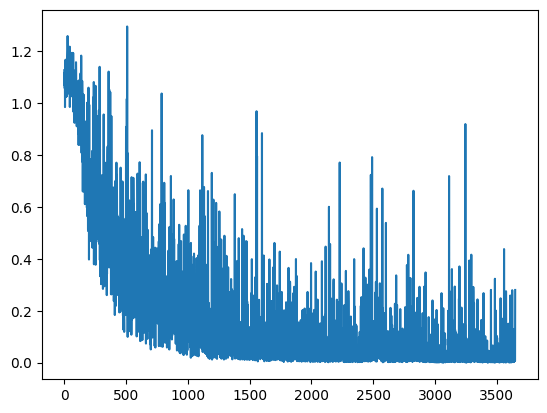

In [6]:
import matplotlib.pyplot as plt
plt.plot(training_loss)

In [7]:
# Evaluation
model.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)  # Raw logits
        probs = F.softmax(outputs, dim=1)  # Convert to probabilities
        preds = torch.argmax(probs, dim=1)  # Get predicted class

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

# Compute AUROC & AUPRC for each class
num_classes = 3
auroc_scores = []
auprc_scores = []

for i in range(num_classes):
    y_true = (all_labels == i).astype(int)  # Convert to binary labels
    y_score = all_probs[:, i]  # Probability of class i
    
    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    auroc_scores.append(auroc)
    auprc_scores.append(auprc)

    print(f"Class {i} - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

100%|██████████| 293/293 [00:43<00:00,  6.74it/s]

Class 0 - AUROC: 0.9294, AUPRC: 0.8603
Class 1 - AUROC: 0.9022, AUPRC: 0.8659
Class 2 - AUROC: 0.9113, AUPRC: 0.8698


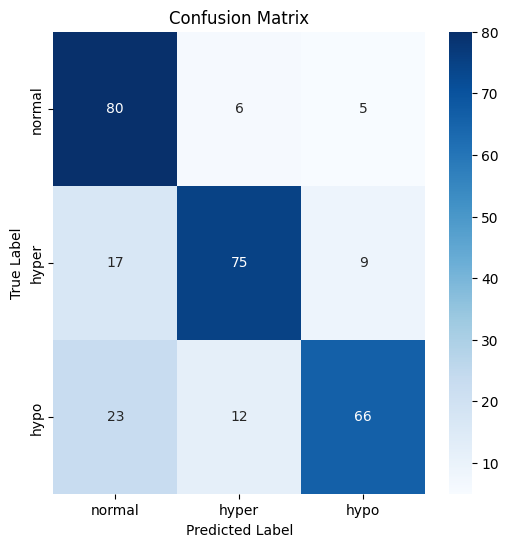

In [8]:
# Compute and Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["normal", "hyper", "hypo"], yticklabels=["normal", "hyper", "hypo"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [9]:
from sklearn.metrics import classification_report
CLASS_NAMES = {'normal': 0, 'hyper': 1, 'hypo': 2}

print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      normal       0.67      0.88      0.76        91
       hyper       0.81      0.74      0.77       101
        hypo       0.82      0.65      0.73       101

    accuracy                           0.75       293
   macro avg       0.77      0.76      0.75       293
weighted avg       0.77      0.75      0.75       293



In [10]:
save_path = "video_classification_model.pth"  # Choose a filename
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to video_classification_model.pth


In [11]:

# Convert data to Pandas DataFrame
df = pd.DataFrame({
    "true_label": all_labels,
    "predicted_label": all_preds
})

# Add probability columns for each class
num_classes = all_probs[0].shape[0]
for i in range(num_classes):
    df[f"prob_class_{i}"] = [prob[i] for prob in all_probs]

# Save as CSV
csv_filename = "predictions.csv"
df.to_csv(csv_filename, index=False)

print(f"Predictions saved to {csv_filename}")

Predictions saved to predictions.csv
